<a href="https://colab.research.google.com/github/claudian37/DS_Portfolio/blob/master/WnB_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and initialize Weights and Biases

Be sure to create an account on [W&B](https://wandb.ai/site) first. 

In [1]:
!pip install wandb

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: clau (use `wandb login --relogin` to force relogin)


True

# Import Data
For simplicity, I used the [California housing dataset from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing) to build a regression model. The dataset contains 8 features and the target is the value of the house in units of 100,000.

In [3]:
from lightgbm import LGBMRegressor
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
dataset = fetch_california_housing()
X = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
y = pd.DataFrame(dataset['target'], columns=['house_value'])

In [5]:
print(X.shape)
X.head()

(20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
print(y.shape)
y.head()

(20640, 1)


,house_value
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values, 
    y.values.ravel(), 
    test_size=0.25, 
    random_state=123
)

baseline_model = LGBMRegressor()
baseline_model.fit(X_train, y_train)
y_preds_baseline = baseline_model.predict(X_test)

mae_baseline = mean_absolute_error(y_test, y_preds_baseline)
mse_baseline = mean_squared_error(y_test, y_preds_baseline)

print(f"LGB baseline model performance: \n MAE Score: {round(mae_baseline, 4)}, MSE Score: {round(mse_baseline, 4)}")

LGB baseline model performance: 
 MAE Score: 0.3059, MSE Score: 0.2077


## Define model training function 
This function will contain several components, including:
- **Set Default configurations:** specify default configurations to start with that will be overwritten during the sweep.
- **Start W&B:** Initialize a newwandb run.
- **Load and split the dataset:** remember to add a seed to your train_test_split function for consistent splits across different runs.
- **Train Model:** fit your model on the train set and use the trained model to predict on the test set.
- **Evaluate model performance:** evaluate the predictions made by trained model. In this case, I chose to use both mean_absolute_error and mean_squared_error as metrics for the regression model. 
- **Log model performance metrics:** record the metrics to W&B using wandb.log().

In [16]:
def train_model():
  # Set default configurations (Defaults will be overwritten during sweep)
  config_defaults = {
      'max_depth': 3, 
      'num_leaves': 15,
      'n_estimators': 50
  }

  # Start W&B
  wandb.init(config=config_defaults)
  config = wandb.config

  # Load and split data
  dataset = fetch_california_housing()
  X = dataset['data']
  y = dataset['target']
  X_train, X_test, y_train, y_test = train_test_split(
      X, 
      y, 
      test_size=0.25, 
      random_state=123
  )

  # Fit regression model on train set
  model = LGBMRegressor(
      max_depth=config.max_depth, 
      num_leaves=config.num_leaves,
      n_estimators=config.n_estimators
  )
  model.fit(X_train, y_train)

  # Predict on test set
  y_preds = model.predict(X_test)
  
  # Evaluate predictions
  mae_score = mean_absolute_error(y_test, y_preds)
  mse_score = mean_squared_error(y_test, y_preds)
  print(f"MAE: {round(mae_score, 4)}, MSE: {round(mse_score, 4)}")

  # Log model performance metrics to W&B
  wandb.log({"mae": mae_score, "mse": mse_score})


## Define sweep configurations
Some parameters to define here include:
- **Method**: specify your search strategy, examples include Bayesian, grid and random searches. 
- **Metric**: define the name and goal (maximize or minimize) of the metric to use as the metric to optimize on. For example, I chose mean squared error (MSE) as my metric and the goal was to minimize this metric. 
- **Parameters**: define the hyperparameters to tune stored as the keys of a dictionary and their corresponding values to search over in the form of a list stored as the values of this dictionary.
For a complete list of sweep configurations, see this [link](https://docs.wandb.ai/guides/sweeps/configuration#search-strategy).

In [17]:
sweep_configs = {
    "method": "grid",
    "metric": {
        "name": "mse",
        "goal": "minimize"
    },
    "parameters": {
        "max_depth": {
            "values": [4, 6, 8, 10]
        },
        "num_leaves": {
            "values": [15, 23, 31, 63, 100]
        },
        "n_estimators": {
            "values": [100, 200, 500, 800, 1000]
        }
    }
}

In [18]:
sweep_id = wandb.sweep(sweep_configs, project="california-housing-sweeps")

Create sweep with ID: zhlex3q9
Sweep URL: https://wandb.ai/clau/california-housing-sweeps/sweeps/zhlex3q9


In [20]:
wandb.agent(sweep_id=sweep_id, function=train_model, count=30)

wandb: Agent Starting Run: xhz4z3vj with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 100
wandb: 	num_leaves: 23


MAE: 0.3404, MSE: 0.2445


mae,▁
mse,▁
mae,0.34042
mse,0.24447


wandb: Agent Starting Run: r5mllz0a with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 100
wandb: 	num_leaves: 31


MAE: 0.3404, MSE: 0.2445


mae,▁
mse,▁
mae,0.34042
mse,0.24447


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 01oel7m7 with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 100
wandb: 	num_leaves: 63


MAE: 0.3404, MSE: 0.2445


mae,▁
mse,▁
mae,0.34042
mse,0.24447


wandb: Agent Starting Run: ggtwudah with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 100
wandb: 	num_leaves: 100


MAE: 0.3404, MSE: 0.2445


mae,▁
mse,▁
mae,0.34042
mse,0.24447


wandb: Agent Starting Run: 99xy1e9n with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 200
wandb: 	num_leaves: 15


MAE: 0.3197, MSE: 0.2218


mae,▁
mse,▁
mae,0.31972
mse,0.22183


wandb: Agent Starting Run: i1pwhaob with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 200
wandb: 	num_leaves: 23


MAE: 0.3188, MSE: 0.2205


mae,▁
mse,▁
mae,0.3188
mse,0.22048


wandb: Agent Starting Run: e850joa7 with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 200
wandb: 	num_leaves: 31


MAE: 0.3188, MSE: 0.2205


mae,▁
mse,▁
mae,0.3188
mse,0.22048


wandb: Agent Starting Run: q0w5i3dt with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 200
wandb: 	num_leaves: 63


MAE: 0.3188, MSE: 0.2205


mae,▁
mse,▁
mae,0.3188
mse,0.22048


wandb: Agent Starting Run: ua4ssmsa with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 200
wandb: 	num_leaves: 100


MAE: 0.3188, MSE: 0.2205


mae,▁
mse,▁
mae,0.3188
mse,0.22048


wandb: Agent Starting Run: t6oz0nk8 with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	num_leaves: 15


MAE: 0.3018, MSE: 0.2029


mae,▁
mse,▁
mae,0.30181
mse,0.20285


wandb: Agent Starting Run: tup943bh with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	num_leaves: 23


MAE: 0.2997, MSE: 0.202


mae,▁
mse,▁
mae,0.2997
mse,0.20202


wandb: Agent Starting Run: ijwu3iba with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31


MAE: 0.2997, MSE: 0.202


mae,▁
mse,▁
mae,0.2997
mse,0.20202


wandb: Agent Starting Run: h9l7jdah with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	num_leaves: 63


MAE: 0.2997, MSE: 0.202


mae,▁
mse,▁
mae,0.2997
mse,0.20202


wandb: Agent Starting Run: 7egri7l8 with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 500
wandb: 	num_leaves: 100


MAE: 0.2997, MSE: 0.202


mae,▁
mse,▁
mae,0.2997
mse,0.20202


wandb: Agent Starting Run: pfki3ut6 with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 800
wandb: 	num_leaves: 15


MAE: 0.2946, MSE: 0.1964


mae,▁
mse,▁
mae,0.29456
mse,0.19639


wandb: Agent Starting Run: l3m1bhmo with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 800
wandb: 	num_leaves: 23


MAE: 0.2944, MSE: 0.1962


mae,▁
mse,▁
mae,0.29443
mse,0.19616


wandb: Agent Starting Run: 3g1hfwvj with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 800
wandb: 	num_leaves: 31


MAE: 0.2944, MSE: 0.1962


mae,▁
mse,▁
mae,0.29443
mse,0.19616


wandb: Agent Starting Run: das11u2l with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 800
wandb: 	num_leaves: 63


MAE: 0.2944, MSE: 0.1962


mae,▁
mse,▁
mae,0.29443
mse,0.19616


wandb: Agent Starting Run: q3g62cri with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 800
wandb: 	num_leaves: 100


MAE: 0.2944, MSE: 0.1962


mae,▁
mse,▁
mae,0.29443
mse,0.19616


wandb: Agent Starting Run: l20z8u8i with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 15


MAE: 0.2928, MSE: 0.1952


mae,▁
mse,▁
mae,0.29278
mse,0.19521


wandb: Agent Starting Run: j9478cr1 with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 23


MAE: 0.2925, MSE: 0.1948


mae,▁
mse,▁
mae,0.29249
mse,0.19477


wandb: Agent Starting Run: zycfdrar with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31


MAE: 0.2925, MSE: 0.1948


mae,▁
mse,▁
mae,0.29249
mse,0.19477


wandb: Agent Starting Run: w4oqkm1l with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 63


MAE: 0.2925, MSE: 0.1948


mae,▁
mse,▁
mae,0.29249
mse,0.19477


wandb: Agent Starting Run: 1f2z85x4 with config:
wandb: 	max_depth: 4
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 100


MAE: 0.2925, MSE: 0.1948


mae,▁
mse,▁
mae,0.29249
mse,0.19477


wandb: Agent Starting Run: wrmahupx with config:
wandb: 	max_depth: 6
wandb: 	n_estimators: 100
wandb: 	num_leaves: 15


MAE: 0.3269, MSE: 0.23


mae,▁
mse,▁
mae,0.32691
mse,0.22997


wandb: Agent Starting Run: yghdpee2 with config:
wandb: 	max_depth: 6
wandb: 	n_estimators: 100
wandb: 	num_leaves: 23


MAE: 0.3165, MSE: 0.2196


mae,▁
mse,▁
mae,0.31653
mse,0.21956


wandb: Agent Starting Run: oq51bp90 with config:
wandb: 	max_depth: 6
wandb: 	n_estimators: 100
wandb: 	num_leaves: 31


MAE: 0.3141, MSE: 0.218


mae,▁
mse,▁
mae,0.3141
mse,0.218


wandb: Agent Starting Run: q8shytss with config:
wandb: 	max_depth: 6
wandb: 	n_estimators: 100
wandb: 	num_leaves: 63


MAE: 0.3108, MSE: 0.2129


mae,▁
mse,▁
mae,0.31082
mse,0.21285


wandb: Agent Starting Run: 5acgv52j with config:
wandb: 	max_depth: 6
wandb: 	n_estimators: 100
wandb: 	num_leaves: 100


MAE: 0.3098, MSE: 0.2133


mae,▁
mse,▁
mae,0.30979
mse,0.21332


wandb: Agent Starting Run: 0xas6irg with config:
wandb: 	max_depth: 6
wandb: 	n_estimators: 200
wandb: 	num_leaves: 15


MAE: 0.3103, MSE: 0.212


mae,▁
mse,▁
mae,0.31031
mse,0.21198


# Visualizations

## Hyperparameter Importance Plot

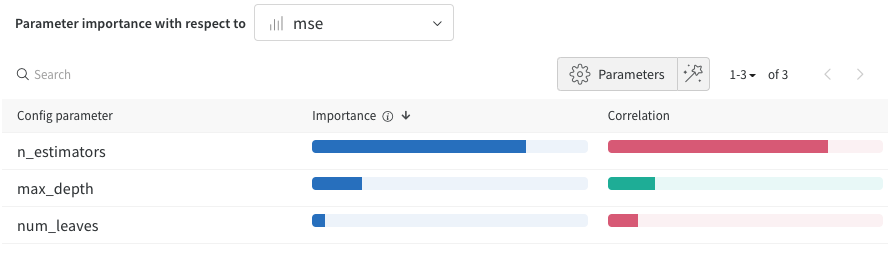

## Parallel Coordinate Plot

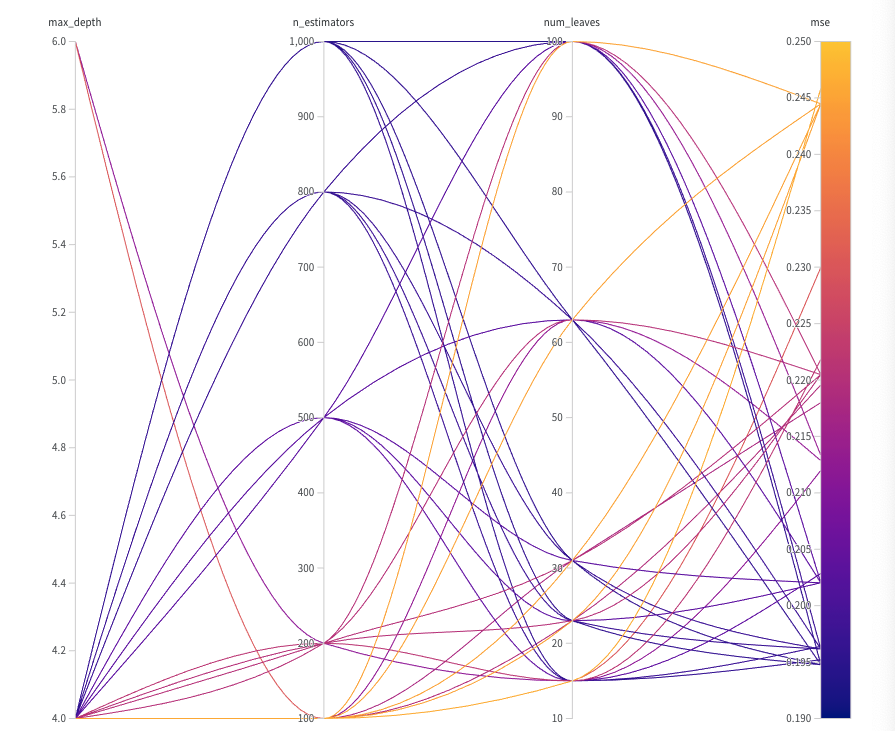